In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Here's some functions I'll use for my own data cleanup efforts

def print_lots_of_info(df):
    df.info(show_counts=True)
    print(df.shape)
    print()
    print(df.describe())
    print()
    print(df.head(5))
    print()
    print(df.sample(5))
    print()

def do_each_col(df):
    for c in df.columns:
        print(c, 'count of unique values =', df[c].nunique())
        # count the number of duplicated values in each column
        mask = df.duplicated(subset=c, keep=False)
        duplicated_values = df.loc[mask, c].unique()
        num_duplicates = len(duplicated_values)
        if num_duplicates > 0:
            print(f"Column '{c}' has {num_duplicates} duplicated values: {duplicated_values}")
        print()

## Find and remove duplicate values (and describe why you make your choices)

### `orders` data frame

In [24]:
# Change Column Names, Check for duplicated orders, and Drop duplicated orders
i_df = pd.read_csv('./data/instacart_orders.csv', sep=';')
i_df = i_df.rename(columns={
    'order_number': 'user_order_number',
    'order_dow': 'day_of_week_numeral'
})
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])
i_df = i_df.drop_duplicates()

In [25]:
# Make a new day_of_week column, for future readability
weekday_dict = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}

i_df['day_of_week'] = i_df['day_of_week_numeral'].map(weekday_dict)
# print_lots_of_info(i_df)
# do_each_col(i_df)


In [26]:
# Change Col data types to save space and make it easier to use the data later

i_df['order_id'] = i_df['order_id'].astype(str)
i_df = i_df.reset_index(drop=True)

# print(np.array_equal(i_df['user_order_number'], i_df['user_order_number'].astype('uint8')))
i_df['user_order_number'] = i_df['user_order_number'].astype('uint8')

# print(np.array_equal(i_df['day_of_week_numeral'], i_df['day_of_week_numeral'].astype('uint8')))
i_df['day_of_week_numeral'] = i_df['day_of_week_numeral'].astype('uint8')

# print(np.array_equal(i_df['order_hour_of_day'], i_df['order_hour_of_day'].astype('uint8')))
i_df['order_hour_of_day'] = i_df['order_hour_of_day'].astype('uint8')

i_df['days_since_prior_order'] = i_df['days_since_prior_order'].fillna(-1)
# print(np.array_equal(i_df['days_since_prior_order'], i_df['days_since_prior_order'].astype('int8')))
i_df['days_since_prior_order'] = i_df['days_since_prior_order'].astype('int8')

# print_lots_of_info(i_df)


### `products` data frame

In [27]:
# Check for fully duplicate rows
p_df = pd.read_csv('./data/products.csv', sep=';')
p_df = p_df.rename(columns={
    'product_name': 'name'
})
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0])

In [28]:
# Set index, fill na values, and Change Col data types to save space and
# to make it easier to use the data later
p_df['product_id'] = p_df['product_id'].astype(str)
p_df = p_df.reset_index(drop=True)

p_df['aisle_id'] = p_df['aisle_id'].astype(str)
p_df['department_id'] = p_df['department_id'].astype(str)
p_df['name'].fillna('__unknown__', inplace=True)
p_df['name'] = p_df['name'].str.lower()
# print_lots_of_info(p_df)

In [29]:
# Check for just duplicate product names (convert names to lowercase to compare better)
# print(i_df.duplicated().value_counts(), 'out of', i_df.shape[0]) 
# there are no duplicates

### `departments` data frame

In [30]:
d_df = pd.read_csv('./data/departments.csv', sep=';')
d_df = d_df.rename(columns={
    'department': 'name'
})

# print(d_df.duplicated().value_counts(), 'out of', d_df.shape[0])

In [31]:
d_df['department_id'] = d_df['department_id'].astype(str)
d_df = d_df.reset_index(drop=True)
# print_lots_of_info(d_df)

### `aisles` data frame

In [32]:
a_df = pd.read_csv('./data/aisles.csv', sep=';')
a_df = a_df.rename(columns={
    'aisle': 'name'
})

# print(a_df.duplicated().value_counts(), 'out of', a_df.shape[0])

In [33]:
a_df['aisle_id'] = a_df['aisle_id'].astype(str)
a_df = a_df.reset_index(drop=True)

# print_lots_of_info(a_df)

### `order_products` data frame

In [34]:
# Check for fullly duplicate rows
o_df = pd.read_csv('./data/order_products.csv', sep=';')
o_df = o_df.rename(columns={
    'add_to_cart_order': 'cart_item_id'
})

o_df = o_df.dropna(subset=['cart_item_id'])

# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

In [35]:
# Double check for any other tricky duplicates
o_df['order_id'] = o_df['order_id'].astype(str)
o_df['product_id'] = o_df['product_id'].astype(str)
# print(np.array_equal(o_df['cart_item_id'], o_df['cart_item_id'].astype('uint8')))
o_df['cart_item_id'] = o_df['cart_item_id'].astype('uint8')
# print(np.array_equal(o_df['reordered'], o_df['reordered'].astype('uint8')))
o_df['reordered'] = o_df['reordered'].astype('uint8')
# print_lots_of_info(o_df)
# print(o_df.duplicated().value_counts(), 'out of', o_df.shape[0])

# [A] Easy (must complete all to pass)

### [A1] Verify that the `'order_hour_of_day'` and `'day_of_week_numeral'` values in the `instacart_orders` tables are sensible (i.e. `'order_hour_of_day'` ranges from 0 to 23 and `'day_of_week_numeral'` ranges from 0 to 6)

In [36]:
print(pd.Series(i_df['day_of_week_numeral'].unique()).sort_values())

2    0
5    1
6    2
4    3
3    4
1    5
0    6
dtype: uint8


In [37]:
print(pd.Series(i_df['order_hour_of_day'].unique()).sort_values())

12     0
15     1
18     2
20     3
23     4
22     5
17     6
16     7
5      8
9      9
11    10
4     11
1     12
0     13
13    14
7     15
8     16
14    17
6     18
2     19
3     20
19    21
10    22
21    23
dtype: uint8


The days of the Week and the Hours of the day look good. No missing values. No nonsense values.

### [A2] What time of day do people shop for groceries?

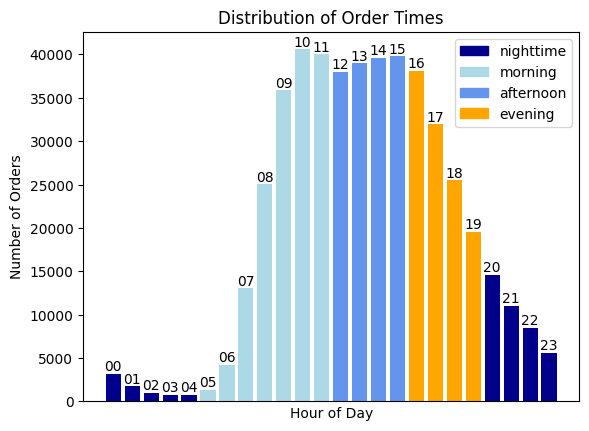

In [38]:
# Make an optically pleasing color scheme
colors=[
    'darkblue','darkblue','darkblue','darkblue','darkblue', # Nighttime 20-04
    'lightblue','lightblue','lightblue','lightblue','lightblue','lightblue','lightblue', # Morning 05-11
    'cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue', # Afternoon 12-15
    'orange','orange','orange','orange', # Evening 16-19
    'darkblue','darkblue','darkblue','darkblue' # Nighttime 20-04
]
color_labels = {
    'nighttime': 'darkblue',
    'morning': 'lightblue',
    'afternoon': 'cornflowerblue',
    'evening': 'orange'
}

# compute the histogram
hist, bins = np.histogram(i_df['order_hour_of_day'], bins=24)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    time_bin = (bins[i], bins[i+1])
    color=colors[i]
    ax.bar(i, hist[i], color=color)
    ax.text(i, hist[i]+0.005, '{:02d}'.format(i), ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Times')

# make a handy legend
handles = [plt.Rectangle((0,0),1,1, color=color_labels[label]) for label in color_labels]
labels = color_labels.keys()
ax.legend(handles, labels)

plt.show()


It appears nighttime is not a popular time to order groceries, I'd speculate that that's because a lot of stores are closed during those times and also 'normal' people sleep during those times. Looks like popular times are late Mornings and Late Afternoon.

### [A3] What day of the week do people shop for groceries?

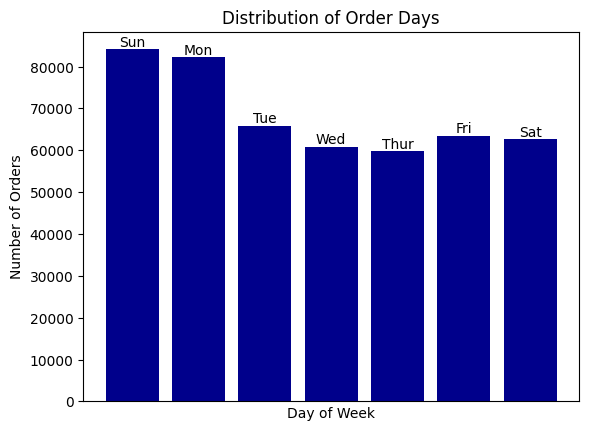

In [39]:
# print(i_df.groupby(['day_of_week_numeral']).size().sort_values(ascending=False))
dow = ["Sun", "Mon", "Tue", "Wed", "Thur", "Fri", "Sat"]

# compute the histogram
hist, bins = np.histogram(i_df['day_of_week_numeral'], bins=7)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins) - 1):
    ax.bar(i, hist[i], color='darkblue')
    ax.text(i, hist[i]+0.005, dow[i], ha='center', va='bottom') # Set the hourly labels to the top of the bars
    
# customize the plot
ax.set_xticks([]) # Hide the ticks at the bottom, since I already have that information at the top
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Days')

plt.show()

Looks like Sunday and Monday are popular Days. I'd speculate that that's because a lot of people plan their weeks on those days and remember that they need Food that week.

### [A4] How long do people wait until placing another order?

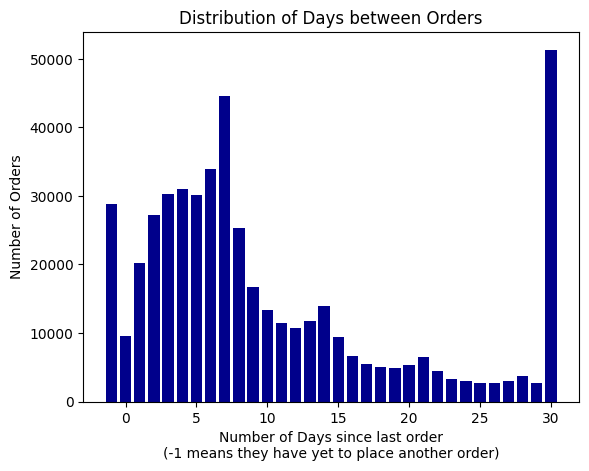

In [40]:
# compute the histogram
hist, bins = np.histogram(i_df['days_since_prior_order'], bins=32)

# create the plot
fig, ax = plt.subplots()
for i in range(len(bins)-1):
    i = i - 1
    ax.bar(i, hist[i+1], color='darkblue')
    
# customize the plot
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_xlabel('Number of Days since last order\n(-1 means they have yet to place another order)', fontsize=10)
ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Days between Orders')

plt.show()

It looks like the most popular interval is listed as 30 days, maybe the data is supposed to represent '30 or more' days or something like that. In second place is 7 days, which makes sense since a lot of people plan their lives on a weekly basis.

# [B] Medium (must complete all to pass)

### [B1] Is there a difference in `'order_hour_of_day'` distributions on Wednesdays and Saturdays? Plot the histograms for both days and describe the differences that you see.

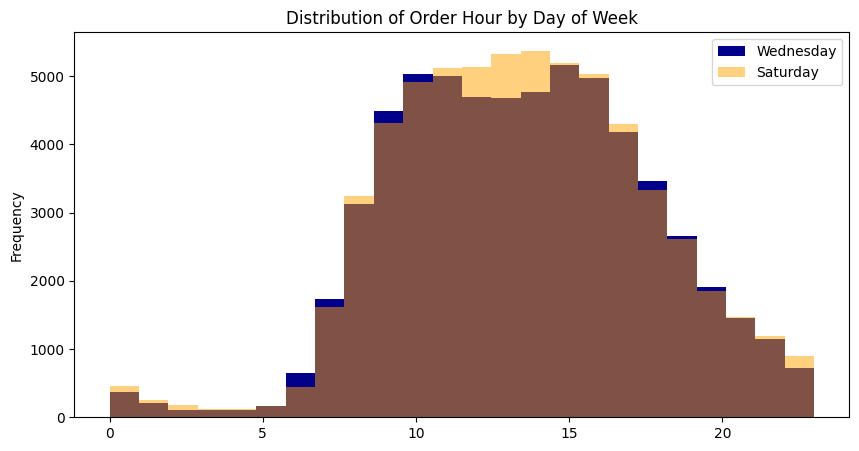

In [41]:
# create two subsets of the data for Wednesdays and Saturdays
wed_df = i_df[i_df['day_of_week'] == 'Wednesday']
sat_df = i_df[i_df['day_of_week'] == 'Saturday']

# create the histogram for Wednesdays
wed_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=1, 
    label='Wednesday', 
    color='darkblue',
    xlabel='Order Hour of Day',
    ylabel='Number of Orders',
    title='Distribution of Order Hour by Day of Week',
    legend=True,
    figsize=[10,5]
)

# create the histogram for Saturdays
sat_df['order_hour_of_day'].plot(
    kind='hist', 
    bins=24, 
    alpha=0.5, 
    label='Saturday', 
    color='orange',
    legend=True
)

plt.show()


It would appear that slightly more orders are placed in the afternoon on Saturdays than on Wednesdays. That makes sense since most people have Sundays off and work on Wednesdays, so they're free to order Groceries.

### [B2] What's the distribution for the number of orders per customer?

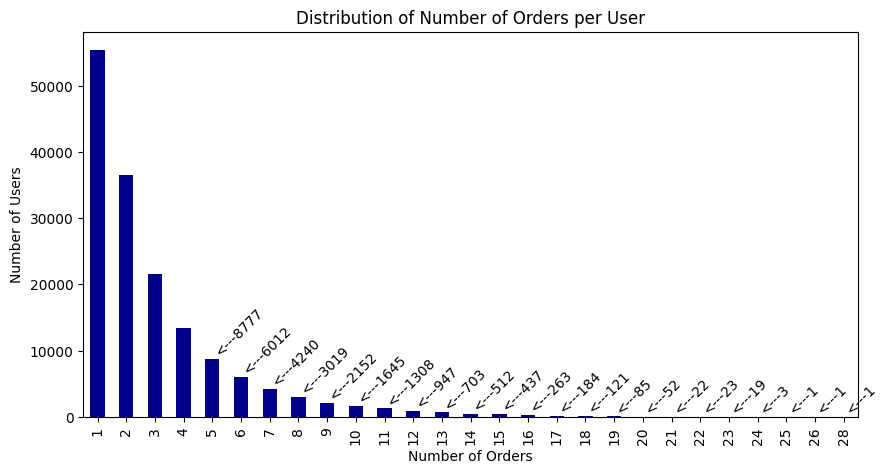

In [42]:
# Count the number of orders per user
user_order_counts = i_df.groupby('user_id')['order_id'].count()

# Count the number of users who have ordered each number of orders
order_counts = user_order_counts.value_counts()

# Sort the order_counts DataFrame by index
order_counts = order_counts.sort_index()

# Create a bar chart with the number of orders on the x-axis and the number of users on the y-axis
order_counts.plot(
    kind='bar',
    xlabel='Number of Orders',
    ylabel='Number of Users',
    title='Distribution of Number of Orders per User',
    color='darkblue',
    figsize=[10, 5]
)

# Add labels to each bar with a value less than 10,000
for i, v in enumerate(order_counts.values):
    if v < 10_000:
        plt.text(i, v, '<---'+str(v), color='black', ha='left', va='bottom', rotation=45)

# Display the plot
plt.show()


It looks like the most common quantity of orders per customer is 1 with what seems to be a moderate logorithmic decline after. Maybe we can add some additional incentives for users to order more. For example, a discount for every 5th or 7th order.

One Customer seems to have ordered 28 times, though. 

### [B3] What are the top 20 popular products (display their id and name)?

In [43]:
# Isolate product ids (and frequencies) of the top 20 most frequently Ordered Products from the order_products df
order_freq_full = o_df.groupby('product_id')['order_id'].count().sort_values(ascending=False).reset_index()
order_freq_full = order_freq_full.rename(columns={'order_id': 'times_ordered'})
order_freq = order_freq_full.head(20)

# Check Data
print(order_freq)

   product_id  times_ordered
0       24852          66046
1       13176          53295
2       21137          37035
3       21903          33970
4       47209          29772
5       47766          24689
6       47626          21495
7       16797          20017
8       26209          19689
9       27845          19600
10      27966          19194
11      22935          15897
12      24964          15290
13      45007          14584
14      39275          13879
15      49683          13674
16      28204          12544
17       5876          12231
18       8277          11992
19      40706          11781


In [44]:
# Map product_id to id in p_df and add the name column
# order_freq['name'] = order_freq['product_id'].apply(lambda x: p_df.set_index('product_id').loc[x, 'name'])
order_freq = order_freq.merge(p_df[['product_id', 'name']], on='product_id')


# Display order_freq
print(order_freq[['product_id', 'name', 'times_ordered']])

   product_id                      name  times_ordered
0       24852                    banana          66046
1       13176    bag of organic bananas          53295
2       21137      organic strawberries          37035
3       21903      organic baby spinach          33970
4       47209      organic hass avocado          29772
5       47766           organic avocado          24689
6       47626               large lemon          21495
7       16797              strawberries          20017
8       26209                     limes          19689
9       27845        organic whole milk          19600
10      27966       organic raspberries          19194
11      22935      organic yellow onion          15897
12      24964            organic garlic          15290
13      45007          organic zucchini          14584
14      39275       organic blueberries          13879
15      49683            cucumber kirby          13674
16      28204        organic fuji apple          12544
17       5

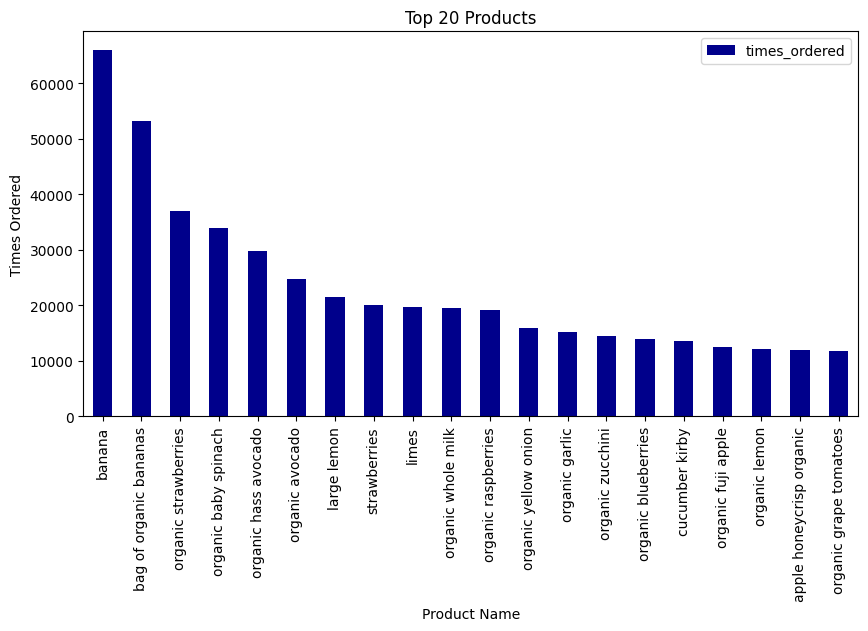

In [45]:
# Make a Bar Chart
order_freq.plot(
    kind='bar',
    x='name',
    y='times_ordered',
    xlabel='Product Name',
    ylabel='Times Ordered',
    color='darkblue',
    title='Top 20 Products',
    figsize=[10, 5],
    rot=90
)

# Display the plot
plt.show()

# [C] Hard (must complete at least two to pass)

### [C1] How many items do people typically buy in one order? What does the distribution look like?

In [46]:
# Find max cart_id per order
items_per_order = o_df.groupby('order_id')['cart_item_id'].max()

# print(items_per_order.sample(10))


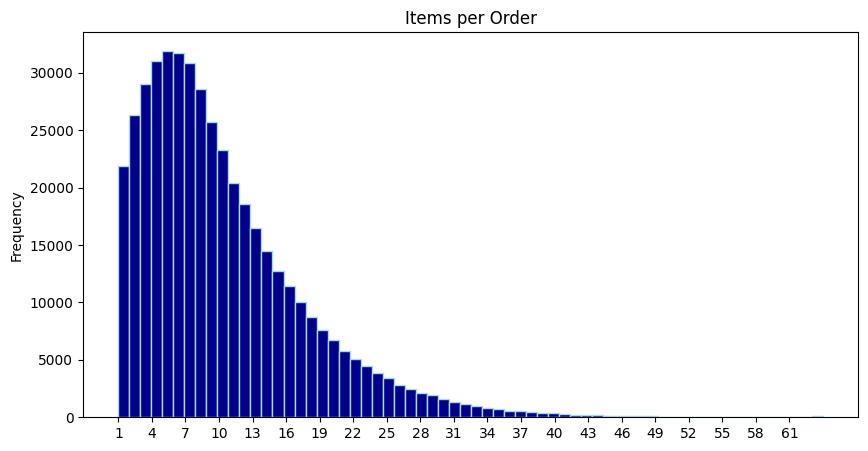

In [47]:
items_per_order.plot(
    kind='hist',
    bins=64,
    xticks=range(1, 64, 3),
    edgecolor='lightblue',
    color='darkblue',
    xlabel='Items in Cart',
    ylabel='Number of Orders',
    title='Items per Order',
    figsize=[10, 5]
)

plt.show()

It seems most order have between 2 and 9 items.

### [C2] What are the top 20 items that are reordered most frequently (display their names and product IDs)?

In [48]:
# Find 20 most reordered items grouped by product_ids
most_reordered = o_df.groupby('product_id')['reordered'].sum().sort_values(ascending=False).head(20).reset_index()

# Display reorder_freq
print(most_reordered)
# rename column
most_reordered = most_reordered.rename(columns={'reordered': 'times_reordered'})


   product_id  reordered
0       24852      55761
1       13176      44448
2       21137      28637
3       21903      26232
4       47209      23628
5       47766      18743
6       27845      16251
7       47626      15044
8       27966      14747
9       16797      13944
10      26209      13326
11      22935      11144
12      24964      10409
13      45007      10076
14      49683       9538
15      28204       8989
16       8277       8835
17      39275       8799
18       5876       8411
19      49235       8389


In [49]:
# Map product_id to id in p_df and add the name column
# most_reordered['name'] = most_reordered['product_id'].apply(lambda x: p_df.set_index('id').loc[x, 'name'])
most_reordered.loc[:, 'name'] = most_reordered['product_id'].apply(lambda x: p_df.set_index('product_id').loc[x, 'name'])

# Display reorder_freq
print(most_reordered)

   product_id  times_reordered                      name
0       24852            55761                    banana
1       13176            44448    bag of organic bananas
2       21137            28637      organic strawberries
3       21903            26232      organic baby spinach
4       47209            23628      organic hass avocado
5       47766            18743           organic avocado
6       27845            16251        organic whole milk
7       47626            15044               large lemon
8       27966            14747       organic raspberries
9       16797            13944              strawberries
10      26209            13326                     limes
11      22935            11144      organic yellow onion
12      24964            10409            organic garlic
13      45007            10076          organic zucchini
14      49683             9538            cucumber kirby
15      28204             8989        organic fuji apple
16       8277             8835 

In [50]:
# Map product_id to id in p_df and add the name column
# most_reordered['times_ordered'] = most_reordered['product_id'].apply(lambda x: order_freq_full.set_index('product_id').loc[x, 'times_ordered'])
most_reordered.loc[:, 'times_ordered'] = most_reordered['product_id'].apply(lambda x: order_freq_full.set_index('product_id').loc[x, 'times_ordered'])

# Display reorder_freq
print(most_reordered)

   product_id  times_reordered                      name  times_ordered
0       24852            55761                    banana          66046
1       13176            44448    bag of organic bananas          53295
2       21137            28637      organic strawberries          37035
3       21903            26232      organic baby spinach          33970
4       47209            23628      organic hass avocado          29772
5       47766            18743           organic avocado          24689
6       27845            16251        organic whole milk          19600
7       47626            15044               large lemon          21495
8       27966            14747       organic raspberries          19194
9       16797            13944              strawberries          20017
10      26209            13326                     limes          19689
11      22935            11144      organic yellow onion          15897
12      24964            10409            organic garlic        

In [51]:
# # Make a Bar Chart
# most_reordered.plot(
#     kind='bar',
#     x='name',
#     y=['times_ordered', 'times_reordered'],
#     xlabel='Product Name',
#     ylabel='Times Reordered',
#     color=['darkblue', 'orange'],
#     title='Top 20 Most Reordered Products',
#     figsize=[10, 5],
#     rot=90
# )

# # Display the plot
# plt.show()

To no one's suprise, it looks like the most reordered items are also the the most ordered from earlier. This isn't very useful, but looking at how many were not reordered might yeild interesting results about product satisfaction...

### [C3] For each product, what proportion of its orders are reorders?

In [52]:
reo_perc = o_df.groupby('product_id')['reordered'].sum().reset_index().rename(columns={'reordered': 'times_reordered'})
reo_perc = reo_perc.merge(order_freq_full[['product_id', 'times_ordered']], on='product_id')

reo_perc['reorder_percentage'] = reo_perc['times_reordered'] / reo_perc['times_ordered']

reo_perc = reo_perc.sort_values(by='times_ordered', ascending=False)

print(reo_perc.head(20))

      product_id  times_reordered  times_ordered  reorder_percentage
15199      24852            55761          66046            0.844275
3224       13176            44448          53295            0.833999
11378      21137            28637          37035            0.773242
12168      21903            26232          33970            0.772211
37919      47209            23628          29772            0.793632
38486      47766            18743          24689            0.759164
38347      47626            15044          21495            0.699884
6930       16797            13944          20017            0.696608
16581      26209            13326          19689            0.676825
18253      27845            16251          19600            0.829133
18373      27966            14747          19194            0.768313
13216      22935            11144          15897            0.701013
15310      24964            10409          15290            0.680772
35670      45007            10076 

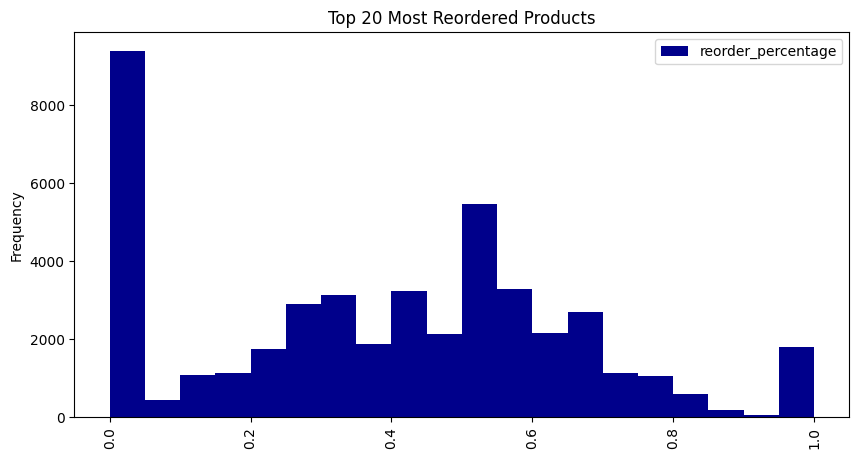

In [53]:
# Make a Bar Chart
reo_perc.plot(
    kind='hist',
    bins=20,
    y='reorder_percentage',
    xlabel='Product Name',
    ylabel='Times Reordered',
    color='darkblue',
    title='Top 20 Most Reordered Products',
    figsize=[10, 5],
    rot=90
)

# Display the plot
plt.show()

### [C4] For each customer, what proportion of their products ordered are reorders?

In [54]:
# users_orders = i_df.groupby(['user_id', 'id']).size().reset_index(name='order_count')
users_orders = i_df.merge(o_df, on='order_id')
grouped_df = users_orders.groupby('user_id').agg({'user_id': 'count', 'reordered': ['sum', 'count']})

grouped_df.columns = ['_'.join(col).rstrip('_') for col in grouped_df.columns.values]
grouped_df['reorder_ratio'] = grouped_df['reordered_sum'] / grouped_df['reordered_count']

print(grouped_df.sample(20))
# Merge the dataframes
# merged_df = pd.merge(i_df, o_df, on=['id', 'order_id'], how='left')

# # Group by user_id and calculate the total number of items and the number of reordered items
# grouped_df = merged_df.groupby('user_id').agg({'id': 'count', 'reordered': 'sum'})
# grouped_df.columns = ['total_items', 'reordered_items']

# # Calculate the proportion of reordered items for each user
# grouped_df['reorder_ratio'] = grouped_df['reordered_items'] / grouped_df['total_items']

# # Display the results
# print(grouped_df.head())


         user_id_count  reordered_sum  reordered_count  reorder_ratio
user_id                                                              
46728                7              2                7       0.285714
176884              25              5               25       0.200000
80793               11              1               11       0.090909
111490              13              5               13       0.384615
119651              14              9               14       0.642857
44691               18             13               18       0.722222
203422              25             14               25       0.560000
24563               79             52               79       0.658228
130342              51             43               51       0.843137
79469               43             33               43       0.767442
31165                4              4                4       1.000000
139721             104             94              104       0.903846
122590              

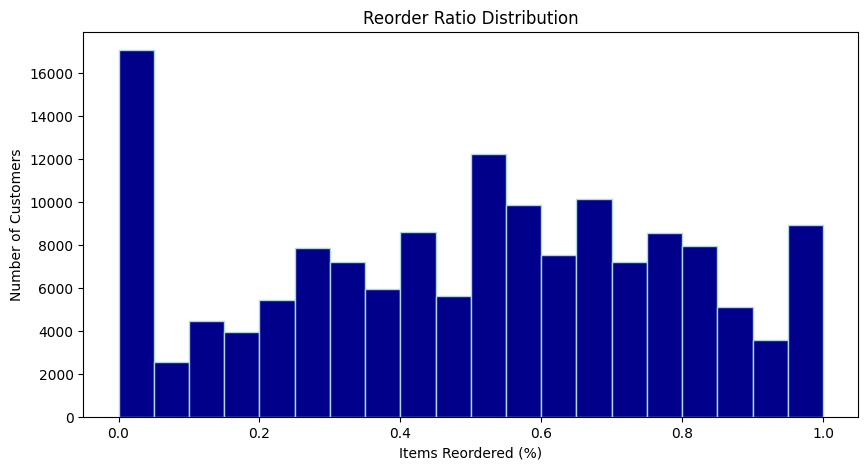

In [55]:
grouped_df['reorder_ratio'].plot(
    kind='hist',
    bins=20,
    title='Reorder Ratio Distribution',
    edgecolor='lightblue',
    color='darkblue',
    figsize=[10, 5]
)

plt.xlabel('Items Reordered (%)')
plt.ylabel('Number of Customers')

plt.show()

### [C5] What are the top 20 items that people put in their carts first? 

In [56]:
first_picks = o_df[o_df['cart_item_id'] == 1].reset_index()

# print(first_picks.sample(20))
# first_picks.info()

In [57]:
first_pick_counts = first_picks.groupby('product_id')['order_id'].count().sort_values(ascending=False).reset_index()

first_pick_counts = first_pick_counts.rename(columns={'order_id': 'times_first'}).head(20)

# print(first_pick_counts)

In [58]:
first_pick_counts['name'] = first_pick_counts['product_id'].apply(lambda x: p_df.set_index('product_id').loc[x, 'name'])

print(first_pick_counts[['name', 'times_first']])

                           name  times_first
0                        banana        15562
1        bag of organic bananas        11026
2            organic whole milk         4363
3          organic strawberries         3946
4          organic hass avocado         3390
5          organic baby spinach         3336
6               organic avocado         3044
7                  spring water         2336
8                  strawberries         2308
9           organic raspberries         2024
10   sparkling water grapefruit         1914
11          organic half & half         1797
12                  large lemon         1737
13                         soda         1733
14     organic reduced fat milk         1397
15                        limes         1370
16                hass avocados         1340
17  organic reduced fat 2% milk         1310
18                  half & half         1309
19         organic yellow onion         1246


It looks like the number of times an item is put into a cart first is proportional to Total orders, except further down the list, it look like people remember they need dairy products like *milk* and *half & half* first.